# Figure 3: Inactivation

In [1]:
# Imports

## General
import os 
from copy import deepcopy
from itertools import product
from types import SimpleNamespace
import sys
sys.path.append("..")
from RNN_helpers import *
from IPython.display import display, Markdown

## Numerical
import numpy as np
import pandas as pd
import scipy.stats as sps
from scipy.stats import ttest_rel
import math
from scipy.stats import linregress
import statsmodels.formula.api as smf
import statsmodels.api as sm
import  statsmodels.stats.multicomp as smmc
from sklearn.neighbors import KernelDensity

## Plotting
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sb

## Data
import csv
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Plotting defaults and functions

%config InlineBackend.figure_format = 'retina'

plt.rcParams['legend.fontsize'] = 'x-small'
plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.labelsize'] = 'x-small'
plt.rcParams['axes.formatter.limits'] = [-2, 3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = 'x-small'
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', family='Arial')
plt.rcParams['axes.labelpad'] = 2.0
plt.rcParams['figure.dpi'] = 100

#Setting Colors
R_COLOR = "#808080"
R_NO_STDP_COLOR = "#B3B3B3"
NNR_COLOR = '#FF767C'
NNR_NO_STDP_COLOR = "#FFBFC1"
INACTIVE_COLOR = 'silver'
MIX_COLOR = "#C07B7E"
ALT_COLOR = MIX_COLOR
MIX_NO_STDP_COLOR = "#D9B9BA"

PRE_STDP_COLOR = mpl.cm.Purples(2/5.)
STDP_COLOR = mpl.cm.Purples(1.)
STDP_CONTROL_COLOR = "#BA98FF"

## Output weight distribution 

loading run 2021-07-07 153529250
loadNetwork: No network_STDP_start.h5
loadNetwork: No network_STDP_end.h5
loadNetwork: No network_FORCE_start.h5
loadNetwork: No network_FORCE_end.h5
loadNetwork: no analysis_informativity.json
loadNetwork: No analysis_balance.json


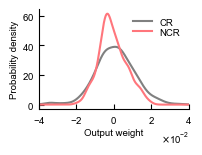

In [24]:
#Setting Variables
NAME = "Output_weights"
DIR = "../results_experiments/full dataset/results_experiment_LIFv2_gross_stdp_halftauIE_x16/"
RUN = "run 2021-07-07 153529250"

# fig, ax = make_axis_size(2, 1, .3, .3)
fig, ax = make_axis_size(1.5, 1, .3, .3)

net = loadNetwork(DIR,RUN,OutputOnly=True)
W_out = net.n.W_out
NNR = np.array(np.where(net.bools.NNR)) 
R = np.array(np.where(net.bools.R))

plot_pdf(W_out[R][0], ax, bandwidth=.3, lim=(-0.04, 0.04), color=R_COLOR, label="CR", lw=1.5)
plot_pdf(W_out[NNR][0], ax, bandwidth=.3, lim=(-0.04, 0.04), color=NNR_COLOR, label="NCR", lw=1.5)
ax.set_xlabel("Output weight")
ax.set_ylabel("Probability density")
ax.legend(labelspacing=.1)

fig.savefig(os.path.join(DIR, NAME+'.pdf'))

In [11]:
sps.levene(W_out[R][0], W_out[NNR][0])

LeveneResult(statistic=23.425858556787162, pvalue=1.6544897188833056e-06)

## Connection strengths


loading run 2021-07-07 153529250
loadNetwork: No network_STDP_start.h5
loadNetwork: No network_STDP_end.h5
loadNetwork: No network_FORCE_start.h5
loadNetwork: No network_FORCE_end.h5
loadNetwork: no analysis_informativity.json
loadNetwork: No analysis_balance.json


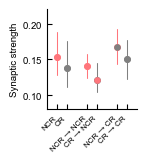

In [25]:
#Setting Variables
NAME = "Weights between populations"
DIR = "../results_experiments/full dataset/results_experiment_LIFv2_gross_stdp_halftauIE_x16/"
RUN = "run 2021-07-07 153529250"
net = loadNetwork(DIR,RUN,OutputOnly=True)


# (axis, margin)
# fig, ax = make_axis_size(1.5, 1, .4, .5)
fig, ax = make_axis_size(.9, 1, .4, .5)

W = np.array(net.n.W)
NNR = np.array(np.where(net.bools.NNR)) + net.p.N_in
R = np.array(np.where(net.bools.R)) + net.p.N_in

NNRto = np.squeeze(np.squeeze(W[:,:])[:,NNR])
NNRtoNNR = np.squeeze(np.squeeze(W[NNR,:])[:,NNR])
NNRtoR = np.squeeze(np.squeeze(W[R,:])[:,NNR])

Rto = np.squeeze(np.squeeze(W[:,:])[:,R])
RtoNNR = np.squeeze(np.squeeze(W[NNR,:])[:,R])
RtoR = np.squeeze(np.squeeze(W[R,:])[:,R])

NNRto = NNRto[np.greater(NNRto,0)]
NNRtoNNR = NNRtoNNR[np.greater(NNRtoNNR,0)]
NNRtoR = NNRtoR[np.greater(NNRtoR,0)]

Rto = Rto[np.greater(Rto, 0)]
RtoNNR = RtoNNR[np.greater(RtoNNR,0)]
RtoR = RtoR[np.greater(RtoR,0)]

#Pre-Post comparison
data0 = NNRto.flatten()
data1 = NNRtoNNR.flatten()
data2 = NNRtoR.flatten()

data3 = Rto.flatten()
data4 = RtoNNR.flatten()
data5 = RtoR.flatten()

la0 = "NCR"
la1 = "NCR → NCR"
la2 = "NCR → CR"

la3 = "CR"
la4 = "CR → NCR"
la5 = "CR → CR"

groups = [[data0,la0, NNR_COLOR, NNR_COLOR],
          [data3,la3, R_COLOR, R_COLOR],
          [data1,la1, NNR_COLOR, NNR_COLOR],
          [data4,la4, R_COLOR, NNR_COLOR],
          [data2,la2, NNR_COLOR, R_COLOR],
          [data5,la5, R_COLOR, R_COLOR]]


xticks = []
xtick_labels = []
for i, (data, la, color, incolor) in enumerate(groups):
    if (i > 1) & (i <=3):
        i+=1
    elif i > 3:
        i+=2

    vals = data

    median = np.percentile(vals, 50)
    q3 = np.percentile(vals, 75)
    q1 = np.percentile(vals, 25)

    scale=2
    ax.plot([i,i], [q1, q3], linewidth=.75, solid_capstyle='round', color=color, zorder=1)
    ax.scatter(i, median, s=scale*8, color=color, zorder=1)
    ax.scatter(i, median, color=incolor, s=scale*7, zorder=2)
    
    xticks.append(i)
    xtick_labels.append(la)
ax.set_xticks([])
ax.set_xlim([-1, 8])
ax.set_ylim([.08, .22])
ax.set_yticks([.1, .15, .2])
ax.set_xticks(xticks)

fig.savefig(os.path.join(DIR, NAME+' no labels.pdf'))

ax.set_ylabel("Synaptic strength")
ax.set_xticklabels(xtick_labels,rotation=45, ha='right', fontsize="xx-small")
fig.savefig(os.path.join(DIR, NAME+' labels.pdf'),facecolor='white')

#Saving CSV
datadict = dict()
maxl = max(len(data1),len(data2),len(data3),len(data4))

temp = np.zeros(maxl)
temp[:] = np.nan
temp[range(len(data0))] = data0
datadict['NCR'] = deepcopy(temp)

temp = np.zeros(maxl)
temp[:] = np.nan
temp[range(len(data1))] = data1
datadict['NCR to NCR'] = deepcopy(temp)

temp = np.zeros(maxl)
temp[:] = np.nan
temp[range(len(data2))] = data2
datadict['NCR to CR'] = deepcopy(temp)

temp = np.zeros(maxl)
temp[:] = np.nan
temp[range(len(data3))] = data3
datadict['CR'] = deepcopy(temp)

temp = np.zeros(maxl)
temp[:] = np.nan
temp[range(len(data4))] = data4
datadict['CR to NCR'] = deepcopy(temp)

temp = np.zeros(maxl)
temp[:] = np.nan
temp[range(len(data5))] = data5
datadict['CR to CR'] = deepcopy(temp)

df = pd.DataFrame(data=datadict)
df.to_csv(os.path.join(DIR,RUN, NAME+'.csv'))

In [12]:
print(sps.mannwhitneyu(datadict['CR'], datadict['NCR']))
print(sps.mannwhitneyu(datadict['CR to CR'], datadict['NCR to CR']))
print(sps.mannwhitneyu(datadict['CR to NCR'], datadict['NCR to NCR']))

MannwhitneyuResult(statistic=90629794.0, pvalue=0.0)
MannwhitneyuResult(statistic=79986630.0, pvalue=0.0)
MannwhitneyuResult(statistic=71269255.0, pvalue=0.0)


## Firing rates

loading run 2021-07-07 153529250
loadNetwork: No network_STDP_start.h5
loadNetwork: No network_STDP_end.h5
loadNetwork: No network_FORCE_start.h5
loadNetwork: No network_FORCE_end.h5
loadNetwork: no analysis_informativity.json
loadNetwork: No analysis_balance.json


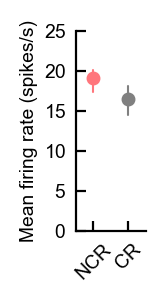

In [4]:
NAME = "Firing_rates_between_populations"
DIR = "../results_experiments/full dataset/results_experiment_LIFv2_gross_stdp_halftauIE_x16/"
RUN = "run 2021-07-07 153529250"

# (axis, margin)
# fig, ax = make_axis_size(.7, 1, .3, .2)
fig, ax = make_axis_size(.35, 1, .3, .3)
net = loadNetwork(DIR,RUN,OutputOnly=True)

FR = np.array(net.FR)
NNR = FR[np.where(net.bools.NNR)]
R = FR[np.where(net.bools.R)]

xticks = []
xtick_labels = []

#cmap = ListedColormap([R_COLOR,NNR_COLOR])
#plt.bar([1,2],[np.mean(NNR),np.mean(R)],width=0.75,color=cmap([1,0]))
#ax.errorbar([1,2],[np.mean(NNR),np.mean(R)],yerr=[np.std(NNR),np.std(R)],c='k',lw=0,elinewidth=1,capsize=10)
#plt.xticks(ticks=[],labels=[])

scale=2

median = np.percentile(NNR, 50)
q3 = np.percentile(NNR, 75)
q1 = np.percentile(NNR, 25)
ax.plot([1,1], [q1, q3], linewidth=0.75, solid_capstyle='round', color=NNR_COLOR, zorder=1)
ax.scatter(1, median, s=scale*8, color=NNR_COLOR, zorder=10)

median = np.percentile(R, 50)
q3 = np.percentile(R, 75)
q1 = np.percentile(R, 25)
ax.plot([2,2], [q1, q3], linewidth=.75, solid_capstyle='round', color=R_COLOR, zorder=1)
ax.scatter(2, median, s=scale*8, color=R_COLOR, zorder=10)

ax.set_xlim([0.5,2.5])
ax.set_ylim([0,25])
ax.set_yticks([0,5,10,15, 20, 25])

plt.xticks(ticks=[1,2],labels=['NCR','CR'], rotation=45)
fig.savefig(os.path.join(DIR, NAME+'_no_labels.pdf'))

ax.set_ylabel("Mean firing rate (spikes/s)")
fig.savefig(os.path.join(DIR, NAME+'_labels.pdf'),facecolor='white')

#Saving CSV
datadict = dict()
datadict['label'] = ['NCR','CR']
datadict['mean'] = [np.mean(NNR),np.mean(R)]
datadict['std'] = [np.std(NNR),np.std(R)]
df = pd.DataFrame(data=datadict)
df.to_csv(os.path.join(DIR, RUN, NAME+'.csv'))

In [5]:
np.percentile(NNR, 50) - np.percentile(R, 50)

2.666666030883789

In [7]:
print(f"NCR: {np.percentile(NNR, 50):.2f}")
print(f"CR: {np.percentile(R, 50):.2f}")

NCR: 19.13
CR: 16.46


In [15]:
sps.mannwhitneyu(NNR, R)

MannwhitneyuResult(statistic=21182.5, pvalue=5.121292325229591e-29)

## Inactivation experiments

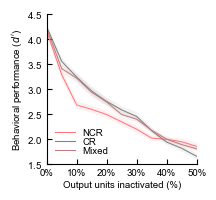

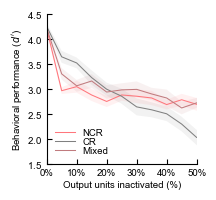

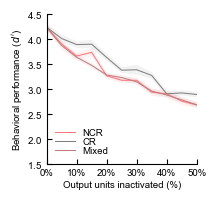

In [13]:
DIRECTORY = "../results_experiments"
VARS = ("n_rep", "inactivation_type","inactivation_num")
# EXPERIMENTS = [("results_experiment_LIFv2_halftauIEsodr", ),
#                ("results_experiment_LIFv2_halftauIEsonr", ), 
#                 ("results_experiment_LIFv2_halftauIEnodr", )]
                
EXPERIMENTS = [("results_experiment_LIFv2_halftauIEsodr", "results_experiment_LIFv2_halftauIEsodrcat", "results_experiment_LIFv2_halftauIEsodrcat2"),
               ("results_experiment_LIFv2_halftauIEsonr", "results_experiment_LIFv2_halftauIEsonrcat", "results_experiment_LIFv2_halftauIEsonrcat2"), 
                ("results_experiment_LIFv2_halftauIEnodr", "results_experiment_LIFv2_halftauIEnodrcat", "results_experiment_LIFv2_halftauIEnodrcat2")]
names = ["full", "output", "recurrent"]
xlim = [0,100]

Stats_all = []
NNRmean_all = []
Rmean_all = []

for idx, exps in enumerate(EXPERIMENTS):
    fig, ax = make_axis_size(1.5, 1.5, .35, .3)
    name = names[idx]

    # Concatenating 
    for j, EXPERIMENT in enumerate(exps):
        if j == 0:
            perf_df = load_experiment_results(EXPERIMENT, "calculate_performance.csv", directory=DIRECTORY) 
        else:
            perf_temp = load_experiment_results(EXPERIMENT, "calculate_performance.csv", directory=DIRECTORY)
            perf_temp["n_rep"] += 8 * j 
            perf_df = perf_df.append(perf_temp)
    n_reps = perf_df["n_rep"].max()
    new_df = perf_df.groupby(['inactivation_type', 'inactivation_num']).mean()
    new_df["d_prime_sem"] = perf_df.groupby(['inactivation_type', 'inactivation_num']).std()["d_prime"] / np.sqrt(n_reps)

    
    for pop, nam, color in zip(["NNR_sorted", "R_sorted", "Alt_sorted"], ["NCR", "CR", "Mixed"],[NNR_COLOR, R_COLOR, MIX_COLOR]):
        c_df = new_df.loc[pop]
        ax.plot(c_df.index, c_df["d_prime"], color=color, label=nam, lw=.75)
        ax.fill_between(c_df.index, c_df["d_prime"] - c_df["d_prime_sem"], c_df["d_prime"] + c_df["d_prime_sem"], alpha=.1, color=color, lw=0)

    # NNRmean = [];NNRsem = [];Rmean = [];Rsem = [];ALTmean = [];ALTsem = []
    # Stats = [];labels = []; 
    # for i in range(0,len(CONDITIONS)):
    #     NNR = [];R = [];ALT = []
    #     org_perf_df.loc[:, ]


    #     for j in range(1, perf_df["n_rep"].max() + 1):
    #         try:
    #             a = org_perf_df.loc[j, CONDITIONS[i][1][0], 'NNR_sorted'][VARIABLE]
    #             try:
    #                 a = a.iloc[0].squeeze()
    #             except:
    #                 pass
    #             NNR.append(a)
    #             a = org_perf_df.loc[j, CONDITIONS[i][1][0], 'R_sorted'][VARIABLE]
    #             try:
    #                 a = a.iloc[0].squeeze()
    #             except:
    #                 pass
    #             R.append(a)
    #             a = org_perf_df.loc[j, CONDITIONS[i][1][0], 'Alt_sorted'][VARIABLE]
    #             try:
    #                 a = a.iloc[0].squeeze()
    #             except:
    #                 pass
    #             ALT.append(a)
    #         except:
    #             pass
    #     NNRmean.append(np.mean(NNR))
    #     NNRsem.append(np.std(NNR)/np.sqrt(len(NNR)))
    #     Rmean.append(np.mean(R))
    #     Rsem.append(np.std(R)/np.sqrt(len(R)))
    #     ALTmean.append(np.mean(ALT))
    #     ALTsem.append(np.std(ALT)/np.sqrt(len(ALT)))
    #     try:
    #         test = ttest_rel(NNR,R)
    #         Stats.append(test[1] * 20)
    #     except Exception as e:
    #         print(e)
    #         Stats.append(1)
    #     labels.append(i)
    # Stats_all.append(Stats)
    # labels = np.array(labels)*(100/max(labels)) #NOTE: THIS ONLY FUNCTIONS IF THE MAX INACTIVATION IS THE FULL NETWORK
    # NNRmean = np.array(NNRmean)
    # NNRmean_all.append(NNRmean)
    # NNRsem = np.array(NNRsem)
    # Rmean = np.array(Rmean)
    # Rmean_all.append(Rmean)
    # Rsem = np.array(Rsem)
    # ALTmean = np.array(ALTmean)
    # ALTsem = np.array(ALTsem)
    # sig = np.less(np.array(Stats), 0.05).nonzero()[0]
    # statstemp = sig
    # sig = [labels[i] for i in sig]
    # ys = np.ones(len(sig))

    # ax.plot(labels, NNRmean, color=NNR_COLOR, linewidth=1, zorder=0)
    # ax.fill_between(labels, NNRmean-NNRsem, NNRmean+NNRsem, color=NNR_COLOR, linewidth=0, zorder=0,alpha=trans,linestyle='None')
    # ax.plot(labels, Rmean, color=R_COLOR, linewidth=1, zorder=0)
    # ax.fill_between(labels, Rmean-Rsem,Rmean+Rsem, color=R_COLOR, linewidth=0, zorder=0,alpha=trans,linestyle='None')
    # ax.plot(labels, ALTmean, color=ALT_COLOR, linewidth=1, zorder=0)
    # ax.fill_between(labels, ALTmean-ALTsem,ALTmean+ALTsem, color=ALT_COLOR, linewidth=0, zorder=0,alpha=trans,linestyle='None')
    # ax.scatter(sig, ys*4.0,c='k',marker="*")

    # org_perf_df = perf_df.set_index(["inactivation_num","inactivation_type"])
    # xticks=[];xlabels=[]
    # for idxx, (label, sel, color) in enumerate(CONDITIONS):
    #     if idxx%6==0:
    #         xticks.append(idxx)
    #         xlabels.append( str(int((int(label)/6)))+"" )
    # #ax.set_xticks(xticks)
    # #ax.set_xticklabels(xlabels)
    # #ax.set_xlim(xticks[0]- .5, xticks[-1]+.5)

    # ax.plot([], [], label="NCR", color=NNR_COLOR, linewidth=1.5, zorder=0)    
    # ax.plot([], [], label="CR", color=R_COLOR, linewidth=1.5, zorder=0) 
    # ax.plot([], [], label="Mixed", color=ALT_COLOR, linewidth=1.5, zorder=0)      

    # if name == "recurrent":
    #     ax.set_ylim([2, 4.5])
    # else:
    ax.legend()
    ax.set_ylim([1.5, 4.5])
    ax.set_xlim([0, 300])
    ax.set_xticks(range(0, 330, 60))
    ax.set_xticklabels([f"{int(i/6)}%" for i in ax.get_xticks()])
    
    NAME = name+' inactivation'
    # fig.savefig(os.path.join(DIRECTORY, NAME+' no labels.pdf'))

    ax.set_xlabel("Output units inactivated (%)")
    #ax.set_xlabel("Number of output units inactivated")
    
    ax.set_ylabel("Behavioral performance ($d'$)")
    ax.legend(loc="lower left", labelspacing=0)
    fig.savefig(os.path.join(DIRECTORY, NAME+'_labels.pdf'),facecolor='white')
    
    #TODO: Save csvs
    # sig2 = np.zeros(len(labels))
    # sig2[np.array(statstemp,dtype=int)] = np.ones(len(statstemp))
    # datadict = dict()
    # datadict['percent inactivation'] = labels
    # datadict['NCR mean'] = NNRmean
    # datadict['NCR sem'] = NNRsem
    # datadict['CR mean'] = Rmean
    # datadict['CR sem'] = Rsem
    # datadict['mixed mean'] = ALTmean
    # datadict['mixed sem'] = ALTsem
    # datadict['significant'] = sig2
    
    # df = pd.DataFrame(data=datadict)
    #df.to_csv(os.path.join(full_dir, NAME+'.csv'))

full:
0:	CR/NCR	1.4984454637534235, 0.0
	CR/bl	1.4984454637534235, 0.0
	NCR/bl	1.4984454637534235, 0.0

10:	CR/NCR	8.32597205861287e-05, -0.6660779822630598
	CR/bl	5.670789085073301e-13, -0.9211621551629436
	NCR/bl	6.60116705366257e-14, -1.5872401374260035

50:	CR/NCR	0.06337704949435327, 0.33248013388028297
	CR/bl	6.276780531759869e-14, -2.607451260014261
	NCR/bl	6.276780531759869e-14, -2.274971126133978

output:
0:	CR/NCR	1.4983432418503209, 0.0
	CR/bl	1.4983432418503209, 0.0
	NCR/bl	1.4983432418503209, 0.0

10:	CR/NCR	0.016220616803326246, -0.6714356577345337
	CR/bl	2.5096360383535285e-08, -0.5740573251477348
	NCR/bl	3.86077174073106e-12, -1.2454929828822685

50:	CR/NCR	0.013410298312104867, 0.5010974552958869
	CR/bl	2.132806925973553e-13, -2.1217397189629064
	NCR/bl	8.241742903144436e-13, -1.6206422636670195

recurrent:
0:	CR/NCR	1.4972760160562177, 0.0
	CR/bl	1.4972760160562177, 0.0
	NCR/bl	1.4972760160562177, 0.0

10:	CR/NCR	0.054242013065431194, -0.30357774369477797
	CR/bl	0.000

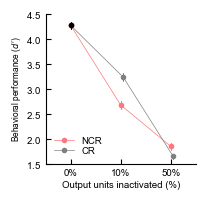

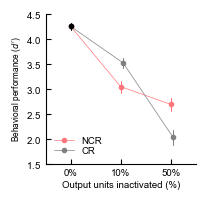

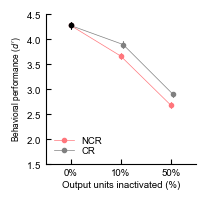

In [14]:
# Plotting as connected plots 
PLOT_NAME = "_specific_inactivation_comparisons"
N1 = 60
N2 = 300
names = ["full", "output", "recurrent"]
comp_num = [(0, 60, 300), (0, 60, 300), (0, 60, 300)]

for idx, (name, exps) in enumerate(zip(names, EXPERIMENTS)):
    fig, ax = make_axis_size(1.5, 1.5, .35, .3)
    # fig, ax = make_axis_size(1.5, 1.0, .35, .3)

    # Concatenating 
    for j, EXPERIMENT in enumerate(exps):
        if j == 0:
            perf_df = load_experiment_results(EXPERIMENT, "calculate_performance.csv", directory=DIRECTORY) 
        else:
            perf_temp = load_experiment_results(EXPERIMENT, "calculate_performance.csv", directory=DIRECTORY)
            perf_temp["n_rep"] += 8 * j 
            perf_df = perf_df.append(perf_temp)
    n_rep = np.max(perf_df["n_rep"])
    d_prime = {}
    legend_handles = []
    sets = ["NCR", "CR"]
    for l, (cond, label, color) in enumerate(zip(["NNR_sorted", "R_sorted"], sets, [NNR_COLOR, R_COLOR])):
        x = l*.05
        # q1 = {}
        # q3 = {}
        m = {}
        s = {}
        d_prime[cond] = {}
        for k, n in enumerate(comp_num[j]):
            if k == 0:
                d_prime[cond][k] = perf_df[(perf_df["inactivation_num"] == n)]['d_prime']
            else:
                d_prime[cond][k] = perf_df[(perf_df['inactivation_type'] == cond) & (perf_df["inactivation_num"] == n)]['d_prime']
            
            # q1[k] = np.percentile(d_prime[cond][k], 25)
            # q3[k] = np.percentile(d_prime[cond][k], 75)
            # m[k]  = np.percentile(d_prime[cond][k], 50)
            
            m[k] = np.mean(d_prime[cond][k])
            s[k] = np.std(d_prime[cond][k]) / np.sqrt(n_rep)
            
            if (n == 0):
                if (cond == "NNR_sorted"):
                    ax.plot(k + x, m[k], linestyle=None, color='k',  marker="o", ms=3, zorder=3)
                    ax.plot([k + x, k + x], [m[k] + s[k], m[k] - s[k]], linewidth=.75, solid_capstyle='round', color='k', zorder=3)
            else:
                # scat_handle = ax.plot(k + x, m[k], linestyle=None, color=color)
                ax.plot([k + x, k + x], [m[k] + s[k], m[k] - s[k]], linewidth=.75, solid_capstyle='round', color=color, zorder=1)
        ax.plot([0, x+1, x+2], [m[0], m[1], m[2]], lw=.5, marker="o", ms=3, color=color, zorder=2, label=label)

    test = sps.mannwhitneyu
    fac = 3
    print(f"{name}:")
    print(f'0:\tCR/NCR\t{test(d_prime["NNR_sorted"][0], d_prime["R_sorted"][0]).pvalue*fac}, {np.median(d_prime["NNR_sorted"][0]) - np.median(d_prime["R_sorted"][0])}')
    print(f'\tCR/bl\t{test(d_prime["R_sorted"][0], d_prime["R_sorted"][0]).pvalue*fac}, {np.median(d_prime["R_sorted"][0]) - np.median(d_prime["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(d_prime["NNR_sorted"][0], d_prime["NNR_sorted"][0]).pvalue*fac}, {np.median(d_prime["NNR_sorted"][0]) - np.median(d_prime["NNR_sorted"][0])}\n')
    
    print(f'10:\tCR/NCR\t{test(d_prime["NNR_sorted"][1], d_prime["R_sorted"][1]).pvalue*fac}, {np.median(d_prime["NNR_sorted"][1]) - np.median(d_prime["R_sorted"][1])}')
    print(f'\tCR/bl\t{test(d_prime["R_sorted"][1], d_prime["R_sorted"][0]).pvalue*fac}, {np.median(d_prime["R_sorted"][1]) - np.median(d_prime["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(d_prime["NNR_sorted"][1], d_prime["NNR_sorted"][0]).pvalue*fac}, {np.median(d_prime["NNR_sorted"][1]) - np.median(d_prime["NNR_sorted"][0])}\n')
    
    print(f'50:\tCR/NCR\t{test(d_prime["NNR_sorted"][2], d_prime["R_sorted"][2]).pvalue*fac}, {np.median(d_prime["NNR_sorted"][2]) - np.median(d_prime["R_sorted"][2])}')
    print(f'\tCR/bl\t{test(d_prime["R_sorted"][2], d_prime["R_sorted"][0]).pvalue*fac}, {np.median(d_prime["R_sorted"][2]) - np.median(d_prime["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(d_prime["NNR_sorted"][2], d_prime["NNR_sorted"][0]).pvalue*fac}, {np.median(d_prime["NNR_sorted"][2]) - np.median(d_prime["NNR_sorted"][0])}\n')


    ax.set_xlim([-.5, 2.5])
    ax.set_ylim([1.5, 4.5])
    ax.set_xticks([0,1, 2])
    ax.set_xticklabels(["0%", "10%", "50%"])
    ax.legend(loc="lower left", labelspacing=0.1)
    ax.set_ylabel("Behavioral performance ($d'$)", size=6)
    ax.set_xlabel("Output units inactivated (%)")
    fig.savefig(os.path.join(DIRECTORY, name + PLOT_NAME+'.pdf'))
    


In [22]:
legend_handles

[([<matplotlib.lines.Line2D at 0x7fc44d0fa410>],
  [<matplotlib.lines.Line2D at 0x7fc44d0fac50>]),
 ([<matplotlib.lines.Line2D at 0x7fc44dffdb10>],
  [<matplotlib.lines.Line2D at 0x7fc44dfe2350>])]

## Inactivation experiments -- Error

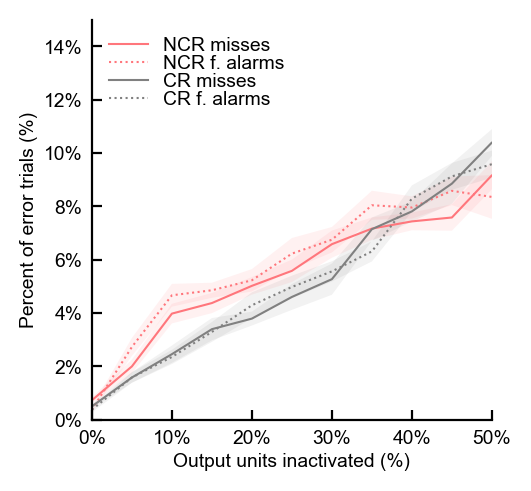

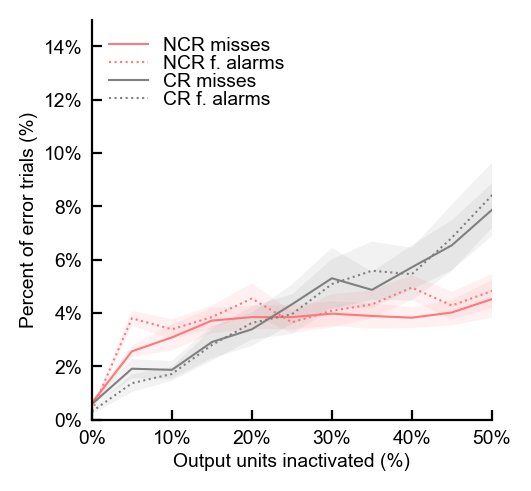

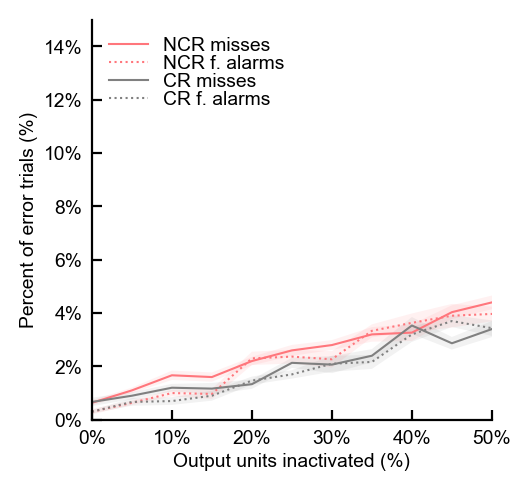

In [65]:
DIRECTORY = "/Users/insanallylab/Desktop/Experiments"
#DIRECTORY = "../results_experiments"
VARS = ("n_rep", "inactivation_type","inactivation_num")
# EXPERIMENTS = [("results_experiment_LIFv2_halftauIEsodr", ),
#                ("results_experiment_LIFv2_halftauIEsonr", ), 
#                 ("results_experiment_LIFv2_halftauIEnodr", )]
                
EXPERIMENTS = [("halftauIEsodr", "halftauIEsodrcat", "halftauIEsodrcat2"),
               ("halftauIEsonr", "halftauIEsonrcat", "halftauIEsonrcat2"), 
                ("halftauIEnodr", "halftauIEnodrcat", "halftauIEnodrcat2")]
names = ["full", "output", "recurrent"]
xlim = [0,100]

Stats_all = []
NNRmean_all = []
Rmean_all = []

for idx, exps in enumerate(EXPERIMENTS):
    fig, ax = make_axis_size(2, 2, .45, .4)
    name = names[idx]

    # Concatenating 
    for j, EXPERIMENT in enumerate(exps):
        if j == 0:
            perf_df = load_experiment_results(EXPERIMENT, "calculate_performance.csv", directory=DIRECTORY) 
        else:
            perf_temp = load_experiment_results(EXPERIMENT, "calculate_performance.csv", directory=DIRECTORY)
            perf_temp["n_rep"] += 8 * j 
            perf_df = perf_df.append(perf_temp)
    n_reps = perf_df["n_rep"].max()
    new_df = perf_df.groupby(['inactivation_type', 'inactivation_num']).mean()
    
    num_trials = (new_df["hits"]+new_df["misses"]+new_df["fAlarms"]+new_df["cRejects"])
    
    #NOTE: dividing by 200 because there are 200 trials in an inactivation session. Would be better to do
    #an elementwise division over the pandas dataframe but I don't know if there's an easy way to do that.
    new_df["misses"] = new_df["misses"]/200*100
    new_df["fAlarms"] = new_df["fAlarms"]/200*100
    new_df["misses_sem"] = perf_df.groupby(['inactivation_type', 'inactivation_num']).std()["misses"]/200*100/ np.sqrt(n_reps)
    new_df["fAlarms_sem"] = perf_df.groupby(['inactivation_type', 'inactivation_num']).std()["fAlarms"]/200*100/ np.sqrt(n_reps)
    
    for pop, nam, color in zip(["NNR_sorted", "R_sorted"], ["NCR", "CR"],[NNR_COLOR, R_COLOR, MIX_COLOR]):
        c_df = new_df.loc[pop]
        
        ax.plot(c_df.index, c_df["misses"], color=color, label=nam+' misses', lw=.75, linestyle='-')
        ax.fill_between(c_df.index, c_df["misses"] - c_df["misses_sem"], c_df["misses"] + c_df["misses_sem"], alpha=.1, color=color, lw=0)
        
        ax.plot(c_df.index, c_df["fAlarms"], color=color, label=nam+' f. alarms', lw=.75, linestyle=':')
        ax.fill_between(c_df.index, c_df["fAlarms"] - c_df["fAlarms_sem"], c_df["fAlarms"] + c_df["fAlarms_sem"], alpha=.1, color=color, lw=0)

    ax.legend()
    ax.set_ylim([0, 15])
    ax.set_xlim([0, 300])
    ax.set_xticks(range(0, 330, 60))
    ax.set_xticklabels([f"{int(i/6)}%" for i in ax.get_xticks()])
    ax.set_yticklabels([f"{int(i)}%" for i in ax.get_yticks()])
    
    NAME = name+' inactivation -- errors'
    # fig.savefig(os.path.join(DIRECTORY, NAME+' no labels.pdf'))

    ax.set_xlabel("Output units inactivated (%)")
    #ax.set_xlabel("Number of output units inactivated")
    
    ax.set_ylabel("Percent of error trials (%)")
    ax.legend(loc="upper left", labelspacing=0)
    fig.savefig(os.path.join(DIRECTORY, NAME+'_labels.pdf'),facecolor='white')
    
    #TODO: Save csvs
    # sig2 = np.zeros(len(labels))
    # sig2[np.array(statstemp,dtype=int)] = np.ones(len(statstemp))
    # datadict = dict()
    # datadict['percent inactivation'] = labels
    # datadict['NCR mean'] = NNRmean
    # datadict['NCR sem'] = NNRsem
    # datadict['CR mean'] = Rmean
    # datadict['CR sem'] = Rsem
    # datadict['mixed mean'] = ALTmean
    # datadict['mixed sem'] = ALTsem
    # datadict['significant'] = sig2
    
    # df = pd.DataFrame(data=datadict)
    #df.to_csv(os.path.join(full_dir, NAME+'.csv'))

full:

misses:
0:	CR/NCR	1.498371502039718, 0.0
	CR/bl	1.498371502039718, 0.0
	NCR/bl	1.498371502039718, 0.0

10:	CR/NCR	0.004180239424117988, 2.25
	CR/bl	2.9372788992217443e-09, 1.5
	NCR/bl	2.7677972017792563e-13, 3.75

50:	CR/NCR	0.10828566285338831, -1.75
	CR/bl	1.5748357787431866e-14, 10.0
	NCR/bl	1.5750098838908554e-14, 8.25


f. alarms:
0:	CR/NCR	1.4983427083526433, 0.0
	CR/bl	1.4983427083526433, 0.0
	NCR/bl	1.4983427083526433, 0.0

10:	CR/NCR	8.8278353459862e-05, 2.0
	CR/bl	1.2947891548707728e-11, 1.75
	NCR/bl	2.1431948945069286e-14, 3.75

50:	CR/NCR	0.0945083388739573, -2.749999999999999
	CR/bl	9.357645252175748e-15, 9.25
	NCR/bl	9.616468887406403e-15, 6.500000000000001


misses vs. f. alarms:
0:	CR/CR	0.0007956192578183587, 0.0
10:	CR/CR	1.4378155245466986, -0.25
50:	CR/CR	0.2586710170746653, 0.75

0:	NCR/NCR	0.0007956192578183587, 0.0
10:	NCR/NCR	0.4868295141160976, 0.0
50:	NCR/NCR	0.20536267171756972, 1.7499999999999991




output:

misses:
0:	CR/NCR	1.4982929552957498, 0.0


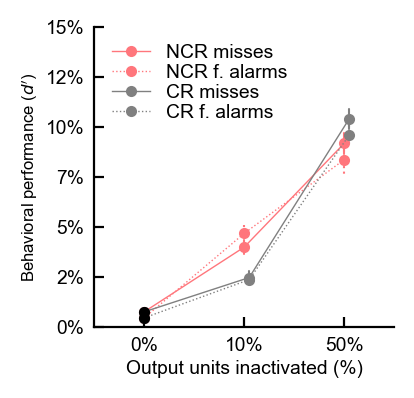

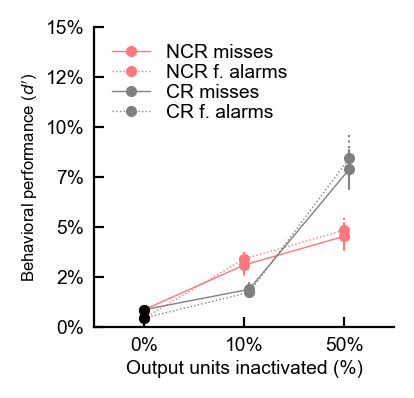

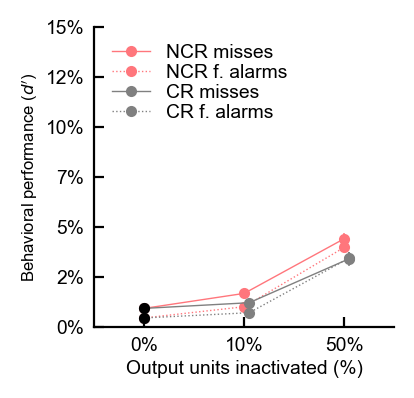

In [66]:
# Plotting as connected plots 
PLOT_NAME = "_specific_inactivation_comparisons"
N1 = 60
N2 = 300
names = ["full", "output", "recurrent"]
comp_num = [(0, 60, 300), (0, 60, 300), (0, 60, 300)]

for idx, (name, exps) in enumerate(zip(names, EXPERIMENTS)):
    fig, ax = make_axis_size(1.5, 1.5, .35, .3)
    # fig, ax = make_axis_size(1.5, 1.0, .35, .3)

    # Concatenating 
    for j, EXPERIMENT in enumerate(exps):
        if j == 0:
            perf_df = load_experiment_results(EXPERIMENT, "calculate_performance.csv", directory=DIRECTORY) 
        else:
            perf_temp = load_experiment_results(EXPERIMENT, "calculate_performance.csv", directory=DIRECTORY)
            perf_temp["n_rep"] += 8 * j 
            perf_df = perf_df.append(perf_temp)
    n_rep = np.max(perf_df["n_rep"])
    misses = {}
    fAlarms = {}
    legend_handles = []
    sets = ["NCR", "CR"]
    for l, (cond, label, color) in enumerate(zip(["NNR_sorted", "R_sorted"], sets, [NNR_COLOR, R_COLOR])):
        x = l*.05
        # q1 = {}
        # q3 = {}
        mm = {}
        sm = {}
        misses[cond] = {}
        mf = {}
        sf = {}
        fAlarms[cond] = {}
        for k, n in enumerate(comp_num[j]):
            if k == 0:
                misses[cond][k] = perf_df[(perf_df["inactivation_num"] == n)]['misses']/200*100
                fAlarms[cond][k] = perf_df[(perf_df["inactivation_num"] == n)]['fAlarms']/200*100
            else:
                misses[cond][k] = perf_df[(perf_df['inactivation_type'] == cond) & (perf_df["inactivation_num"] == n)]['misses']/200*100
                fAlarms[cond][k] = perf_df[(perf_df['inactivation_type'] == cond) & (perf_df["inactivation_num"] == n)]['fAlarms']/200*100
            
            # q1[k] = np.percentile(d_prime[cond][k], 25)
            # q3[k] = np.percentile(d_prime[cond][k], 75)
            # m[k]  = np.percentile(d_prime[cond][k], 50)
            
            #Misses
            mm[k] = np.mean(misses[cond][k])
            sm[k] = np.std(misses[cond][k]) / np.sqrt(n_rep)
            if (n == 0):
                if (cond == "NNR_sorted"):
                    ax.plot(k + x, mm[k], linestyle=None, color='k',  marker="o", ms=3, zorder=3)
                    ax.plot([k + x, k + x], [mm[k] + sm[k], mm[k] - sm[k]], linewidth=.75, solid_capstyle='round', color='k', zorder=3)
            else:
                # scat_handle = ax.plot(k + x, m[k], linestyle=None, color=color)
                ax.plot([k + x, k + x], [mm[k] + sm[k], mm[k] - sm[k]], linewidth=.75, solid_capstyle='round', color=color, zorder=1)
            #fAlarms
            mf[k] = np.mean(fAlarms[cond][k])
            sf[k] = np.std(fAlarms[cond][k]) / np.sqrt(n_rep)
            if (n == 0):
                if (cond == "NNR_sorted"):
                    ax.plot(k + x, mf[k], linestyle=None, color='k',  marker="o", ms=3, zorder=3)
                    ax.plot([k + x, k + x], [mf[k] + sf[k], mf[k] - sf[k]], linewidth=.75, solid_capstyle='round', color='k', zorder=3,linestyle=':')
            else:
                # scat_handle = ax.plot(k + x, m[k], linestyle=None, color=color)
                ax.plot([k + x, k + x], [mf[k] + sf[k], mf[k] - sf[k]], linewidth=.75, solid_capstyle='round', color=color, zorder=1,linestyle=':')
                
        #Misses
        ax.plot([0, x+1, x+2], [mm[0], mm[1], mm[2]], lw=.5, marker="o", ms=3, color=color, zorder=2, label=label+' misses')
        #fAlarms
        ax.plot([0, x+1, x+2], [mf[0], mf[1], mf[2]], lw=.5, marker="o", ms=3, color=color, zorder=2, label=label+' f. alarms',linestyle=':')

    test = sps.mannwhitneyu
    fac = 3
    
    print(f"{name}:")
    print(f"\nmisses:")
    print(f'0:\tCR/NCR\t{test(misses["NNR_sorted"][0], misses["R_sorted"][0]).pvalue*fac}, {np.median(misses["NNR_sorted"][0]) - np.median(misses["R_sorted"][0])}')
    print(f'\tCR/bl\t{test(misses["R_sorted"][0], misses["R_sorted"][0]).pvalue*fac}, {np.median(misses["R_sorted"][0]) - np.median(misses["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(misses["NNR_sorted"][0], misses["NNR_sorted"][0]).pvalue*fac}, {np.median(misses["NNR_sorted"][0]) - np.median(misses["NNR_sorted"][0])}\n')
    
    print(f'10:\tCR/NCR\t{test(misses["NNR_sorted"][1], misses["R_sorted"][1]).pvalue*fac}, {np.median(misses["NNR_sorted"][1]) - np.median(misses["R_sorted"][1])}')
    print(f'\tCR/bl\t{test(misses["R_sorted"][1], misses["R_sorted"][0]).pvalue*fac}, {np.median(misses["R_sorted"][1]) - np.median(misses["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(misses["NNR_sorted"][1], misses["NNR_sorted"][0]).pvalue*fac}, {np.median(misses["NNR_sorted"][1]) - np.median(misses["NNR_sorted"][0])}\n')
    
    print(f'50:\tCR/NCR\t{test(misses["NNR_sorted"][2], misses["R_sorted"][2]).pvalue*fac}, {np.median(misses["NNR_sorted"][2]) - np.median(misses["R_sorted"][2])}')
    print(f'\tCR/bl\t{test(misses["R_sorted"][2], misses["R_sorted"][0]).pvalue*fac}, {np.median(misses["R_sorted"][2]) - np.median(misses["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(misses["NNR_sorted"][2], misses["NNR_sorted"][0]).pvalue*fac}, {np.median(misses["NNR_sorted"][2]) - np.median(misses["NNR_sorted"][0])}\n')
    
    print(f"\nf. alarms:")
    print(f'0:\tCR/NCR\t{test(fAlarms["NNR_sorted"][0], fAlarms["R_sorted"][0]).pvalue*fac}, {np.median(fAlarms["NNR_sorted"][0]) - np.median(fAlarms["R_sorted"][0])}')
    print(f'\tCR/bl\t{test(fAlarms["R_sorted"][0], fAlarms["R_sorted"][0]).pvalue*fac}, {np.median(fAlarms["R_sorted"][0]) - np.median(fAlarms["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(fAlarms["NNR_sorted"][0], fAlarms["NNR_sorted"][0]).pvalue*fac}, {np.median(fAlarms["NNR_sorted"][0]) - np.median(fAlarms["NNR_sorted"][0])}\n')
    
    print(f'10:\tCR/NCR\t{test(fAlarms["NNR_sorted"][1], fAlarms["R_sorted"][1]).pvalue*fac}, {np.median(fAlarms["NNR_sorted"][1]) - np.median(fAlarms["R_sorted"][1])}')
    print(f'\tCR/bl\t{test(fAlarms["R_sorted"][1], fAlarms["R_sorted"][0]).pvalue*fac}, {np.median(fAlarms["R_sorted"][1]) - np.median(fAlarms["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(fAlarms["NNR_sorted"][1], fAlarms["NNR_sorted"][0]).pvalue*fac}, {np.median(fAlarms["NNR_sorted"][1]) - np.median(fAlarms["NNR_sorted"][0])}\n')
    
    print(f'50:\tCR/NCR\t{test(fAlarms["NNR_sorted"][2], fAlarms["R_sorted"][2]).pvalue*fac}, {np.median(fAlarms["NNR_sorted"][2]) - np.median(fAlarms["R_sorted"][2])}')
    print(f'\tCR/bl\t{test(fAlarms["R_sorted"][2], fAlarms["R_sorted"][0]).pvalue*fac}, {np.median(fAlarms["R_sorted"][2]) - np.median(fAlarms["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(fAlarms["NNR_sorted"][2], fAlarms["NNR_sorted"][0]).pvalue*fac}, {np.median(fAlarms["NNR_sorted"][2]) - np.median(fAlarms["NNR_sorted"][0])}\n')
    
    
    print(f"\nmisses vs. f. alarms:")
    print(f'0:\tCR/CR\t{test(misses["R_sorted"][0], fAlarms["R_sorted"][0]).pvalue*fac}, {np.median(misses["R_sorted"][0]) - np.median(fAlarms["R_sorted"][0])}')
    print(f'10:\tCR/CR\t{test(misses["R_sorted"][1], fAlarms["R_sorted"][1]).pvalue*fac}, {np.median(misses["R_sorted"][1]) - np.median(fAlarms["R_sorted"][1])}')
    print(f'50:\tCR/CR\t{test(misses["R_sorted"][2], fAlarms["R_sorted"][2]).pvalue*fac}, {np.median(misses["R_sorted"][2]) - np.median(fAlarms["R_sorted"][2])}\n')
    
    print(f'0:\tNCR/NCR\t{test(misses["NNR_sorted"][0], fAlarms["NNR_sorted"][0]).pvalue*fac}, {np.median(misses["NNR_sorted"][0]) - np.median(fAlarms["NNR_sorted"][0])}')
    print(f'10:\tNCR/NCR\t{test(misses["NNR_sorted"][1], fAlarms["NNR_sorted"][1]).pvalue*fac}, {np.median(misses["NNR_sorted"][1]) - np.median(fAlarms["NNR_sorted"][1])}')
    print(f'50:\tNCR/NCR\t{test(misses["NNR_sorted"][2], fAlarms["NNR_sorted"][2]).pvalue*fac}, {np.median(misses["NNR_sorted"][2]) - np.median(fAlarms["NNR_sorted"][2])}\n')
    
    print(f"\n\n")


    ax.set_xlim([-.5, 2.5])
    ax.set_ylim([0, 15])
    ax.set_xticks([0,1, 2])
    ax.set_xticklabels(["0%", "10%", "50%"])
    ax.set_yticklabels([f"{int(i)}%" for i in ax.get_yticks()])
    ax.legend(loc="upper left", labelspacing=0.1)
    ax.set_ylabel("Behavioral performance ($d'$)", size=6)
    ax.set_xlabel("Output units inactivated (%)")
    fig.savefig(os.path.join(DIRECTORY, name + PLOT_NAME+'.pdf'))
    



## Mean Baseline Activity

0.07195963117486605
0.07195963117486605
0.07195963117486605


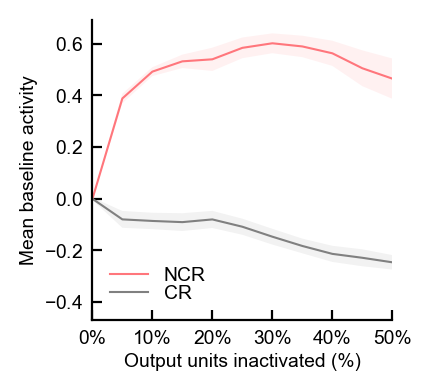

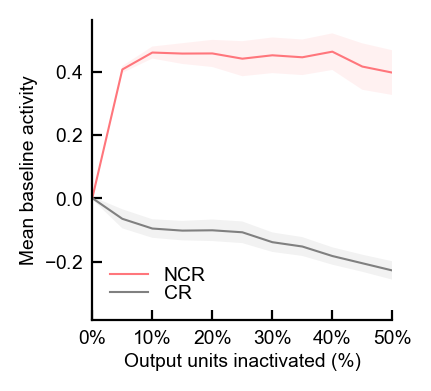

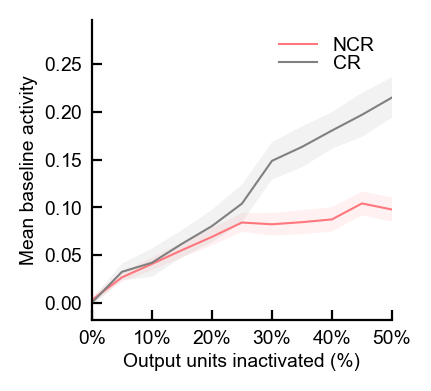

In [67]:
DIRECTORY = "/Users/insanallylab/Desktop/Experiments"
VARS = ("n_rep", "inactivation_type","inactivation_num")
# EXPERIMENTS = [("results_experiment_LIFv2_halftauIEsodr", ),
#                ("results_experiment_LIFv2_halftauIEsonr", ), 
#                 ("results_experiment_LIFv2_halftauIEnodr", )]
                
EXPERIMENTS = [("halftauIEsodr", "halftauIEsodrcat", "halftauIEsodrcat2"),
               ("halftauIEsonr", "halftauIEsonrcat", "halftauIEsonrcat2"), 
                ("halftauIEnodr", "halftauIEnodrcat", "halftauIEnodrcat2")]
names = ["full", "output", "recurrent"]
xlim = [0,100]

Stats_all = []
NNRmean_all = []
Rmean_all = []

for idx, exps in enumerate(EXPERIMENTS):
    fig, ax = make_axis_size(1.5, 1.5, .35, .3)
    name = names[idx]

    # Concatenating 
    for j, EXPERIMENT in enumerate(exps):
        if j == 0:
            perf_df = load_experiment_results(EXPERIMENT, "calculate_RMS_norm.csv", directory=DIRECTORY) 
        else:
            perf_temp = load_experiment_results(EXPERIMENT, "calculate_RMS_norm.csv", directory=DIRECTORY)
            perf_temp["n_rep"] += 8 * j 
            perf_df = perf_df.append(perf_temp)
    n_reps = perf_df["n_rep"].max()
    
    reference_baselines = np.where(list(perf_df.inactivation_num==0))[0]
    rb = np.mean(np.array(list(perf_df.meanshift))[reference_baselines])
    
    print(reference_baseline)
    
    new_df = perf_df.groupby(['inactivation_type', 'inactivation_num']).mean()
    new_df["meanshift_sem"] = perf_df.groupby(['inactivation_type', 'inactivation_num']).std()["meanshift"] / np.sqrt(n_reps)
    
    for pop, nam, color in zip(["NNR_sorted", "R_sorted"], ["NCR", "CR"],[NNR_COLOR, R_COLOR, MIX_COLOR]):
        c_df = new_df.loc[pop]
        ax.plot(c_df.index, c_df["meanshift"]-rb, color=color, label=nam, lw=.75)
        ax.fill_between(c_df.index, c_df["meanshift"]-rb - c_df["meanshift_sem"], c_df["meanshift"]-rb + c_df["meanshift_sem"], alpha=.1, color=color, lw=0)
    ax.legend()
    #ax.set_ylim([1.5, 4.5])
    ax.set_xlim([0, 300])
    ax.set_xticks(range(0, 330, 60))
    ax.set_xticklabels([f"{int(i/6)}%" for i in ax.get_xticks()])
    
    NAME = name+' mean baseline activity inactivation'
    # fig.savefig(os.path.join(DIRECTORY, NAME+' no labels.pdf'))

    ax.set_xlabel("Output units inactivated (%)")
    #ax.set_xlabel("Number of output units inactivated")
    
    ax.set_ylabel("Mean baseline activity")
    ax.legend(labelspacing=0)
    #ax.legend(loc="lower left", labelspacing=0)
    fig.savefig(os.path.join(DIRECTORY, NAME+'_labels.pdf'),facecolor='white')
    
    #TODO: Save csvs
    # sig2 = np.zeros(len(labels))
    # sig2[np.array(statstemp,dtype=int)] = np.ones(len(statstemp))
    # datadict = dict()
    # datadict['percent inactivation'] = labels
    # datadict['NCR mean'] = NNRmean
    # datadict['NCR sem'] = NNRsem
    # datadict['CR mean'] = Rmean
    # datadict['CR sem'] = Rsem
    # datadict['mixed mean'] = ALTmean
    # datadict['mixed sem'] = ALTsem
    # datadict['significant'] = sig2
    
    # df = pd.DataFrame(data=datadict)
    #df.to_csv(os.path.join(full_dir, NAME+'.csv'))

full:
0:	CR/NCR	1.4984456113695968, 0.0
	CR/bl	1.4984456113695968, 0.0
	NCR/bl	1.4984456113695968, 0.0

10:	CR/NCR	4.595496350509755e-09, 0.6009661716413035
	CR/bl	0.0029030321410159895, -0.11567355995966491
	NCR/bl	6.294518358302525e-14, 0.4852926116816386

50:	CR/NCR	1.471730749523908e-07, 0.7645993992795369
	CR/bl	1.246731220118732e-11, -0.25072602388275683
	NCR/bl	5.456110358381086e-10, 0.51387337539678




output:
0:	CR/NCR	1.498343324839631, 0.0
	CR/bl	1.498343324839631, 0.0
	NCR/bl	1.498343324839631, 0.0

10:	CR/NCR	9.955328464496067e-09, 0.5318738967899037
	CR/bl	0.008529232736686317, -0.05723766140074525
	NCR/bl	2.1358524724019634e-13, 0.47463623538915845

50:	CR/NCR	2.01513557332808e-06, 0.7367615860221561
	CR/bl	1.277172505464711e-08, -0.26675108661358016
	NCR/bl	2.2978775415311043e-06, 0.470010499408576




recurrent:
0:	CR/NCR	1.497276300381592, 0.0
	CR/bl	1.497276300381592, 0.0
	NCR/bl	1.497276300381592, 0.0

10:	CR/NCR	0.8007441326162095, 0.017658837455804918
	CR/bl	0.00

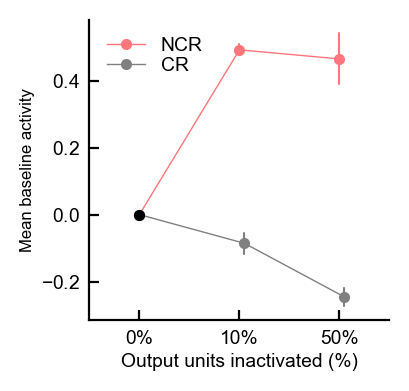

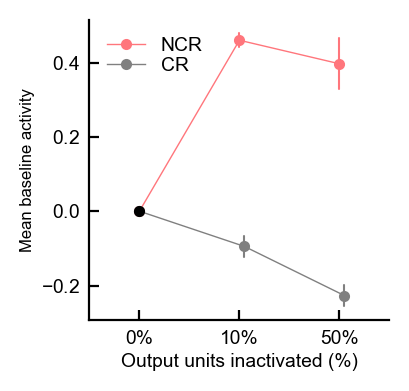

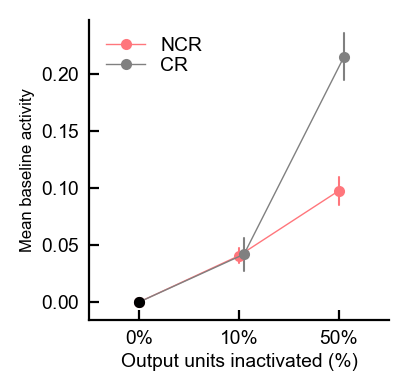

In [68]:
# Plotting as connected plots 
PLOT_NAME = "_specific_inactivation_comparisons_mean_baseline"
N1 = 60
N2 = 300
names = ["full", "output", "recurrent"]
comp_num = [(0, 60, 300), (0, 60, 300), (0, 60, 300)]

for idx, (name, exps) in enumerate(zip(names, EXPERIMENTS)):
    fig, ax = make_axis_size(1.5, 1.5, .35, .3)
    # fig, ax = make_axis_size(1.5, 1.0, .35, .3)

    # Concatenating 
    for j, EXPERIMENT in enumerate(exps):
        if j == 0:
            perf_df = load_experiment_results(EXPERIMENT, "calculate_RMS_norm.csv", directory=DIRECTORY) 
        else:
            perf_temp = load_experiment_results(EXPERIMENT, "calculate_RMS_norm.csv", directory=DIRECTORY)
            perf_temp["n_rep"] += 8 * j 
            perf_df = perf_df.append(perf_temp)
    n_rep = np.max(perf_df["n_rep"])
    
    reference_baselines = np.where(list(perf_df.inactivation_num==0))[0]
    rb = np.mean(np.array(list(perf_df.meanshift))[reference_baselines])
    
    meanshift = {}
    legend_handles = []
    sets = ["NCR", "CR"]
    for l, (cond, label, color) in enumerate(zip(["NNR_sorted", "R_sorted"], sets, [NNR_COLOR, R_COLOR])):
        x = l*.05
        # q1 = {}
        # q3 = {}
        m = {}
        s = {}
        meanshift[cond] = {}
        for k, n in enumerate(comp_num[j]):
            if k == 0:
                meanshift[cond][k] = perf_df[(perf_df["inactivation_num"] == n)]['meanshift'] - rb
            else:
                meanshift[cond][k] = perf_df[(perf_df['inactivation_type'] == cond) & (perf_df["inactivation_num"] == n)]['meanshift'] - rb
            
            # q1[k] = np.percentile(d_prime[cond][k], 25)
            # q3[k] = np.percentile(d_prime[cond][k], 75)
            # m[k]  = np.percentile(d_prime[cond][k], 50)
            
            #Misses
            m[k] = np.mean(meanshift[cond][k])
            s[k] = np.std(meanshift[cond][k]) / np.sqrt(n_rep)
            if (n == 0):
                if (cond == "NNR_sorted"):
                    ax.plot(k + x, m[k], linestyle=None, color='k',  marker="o", ms=3, zorder=3)
                    ax.plot([k + x, k + x], [m[k] + s[k], m[k] - s[k]], linewidth=.75, solid_capstyle='round', color='k', zorder=3)
            else:
                # scat_handle = ax.plot(k + x, m[k], linestyle=None, color=color)
                ax.plot([k + x, k + x], [m[k] + s[k], m[k] - s[k]], linewidth=.75, solid_capstyle='round', color=color, zorder=1)
        #Misses
        ax.plot([0, x+1, x+2], [m[0], m[1], m[2]], lw=.5, marker="o", ms=3, color=color, zorder=2, label=label)

    test = sps.mannwhitneyu
    fac = 3
    
    print(f"{name}:")
    print(f'0:\tCR/NCR\t{test(meanshift["NNR_sorted"][0], meanshift["R_sorted"][0]).pvalue*fac}, {np.median(meanshift["NNR_sorted"][0]) - np.median(meanshift["R_sorted"][0])}')
    print(f'\tCR/bl\t{test(meanshift["R_sorted"][0], meanshift["R_sorted"][0]).pvalue*fac}, {np.median(meanshift["R_sorted"][0]) - np.median(meanshift["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(meanshift["NNR_sorted"][0], meanshift["NNR_sorted"][0]).pvalue*fac}, {np.median(meanshift["NNR_sorted"][0]) - np.median(meanshift["NNR_sorted"][0])}\n')
    
    print(f'10:\tCR/NCR\t{test(meanshift["NNR_sorted"][1], meanshift["R_sorted"][1]).pvalue*fac}, {np.median(meanshift["NNR_sorted"][1]) - np.median(meanshift["R_sorted"][1])}')
    print(f'\tCR/bl\t{test(meanshift["R_sorted"][1], meanshift["R_sorted"][0]).pvalue*fac}, {np.median(meanshift["R_sorted"][1]) - np.median(meanshift["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(meanshift["NNR_sorted"][1], meanshift["NNR_sorted"][0]).pvalue*fac}, {np.median(meanshift["NNR_sorted"][1]) - np.median(meanshift["NNR_sorted"][0])}\n')
    
    print(f'50:\tCR/NCR\t{test(meanshift["NNR_sorted"][2], meanshift["R_sorted"][2]).pvalue*fac}, {np.median(meanshift["NNR_sorted"][2]) - np.median(meanshift["R_sorted"][2])}')
    print(f'\tCR/bl\t{test(meanshift["R_sorted"][2], meanshift["R_sorted"][0]).pvalue*fac}, {np.median(meanshift["R_sorted"][2]) - np.median(meanshift["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(meanshift["NNR_sorted"][2], meanshift["NNR_sorted"][0]).pvalue*fac}, {np.median(meanshift["NNR_sorted"][2]) - np.median(meanshift["NNR_sorted"][0])}\n')
    
    print(f"\n\n")


    ax.set_xlim([-.5, 2.5])
    #ax.set_ylim([0, 15])
    ax.set_xticks([0,1, 2])
    ax.set_xticklabels(["0%", "10%", "50%"])
    #ax.set_yticklabels([f"{int(i)}%" for i in ax.get_yticks()])
    ax.legend(loc="upper left", labelspacing=0.1)
    ax.set_ylabel("Mean baseline activity", size=6)
    ax.set_xlabel("Output units inactivated (%)")
    fig.savefig(os.path.join(DIRECTORY, name + PLOT_NAME+'.pdf'))
    



## Baseline activity std

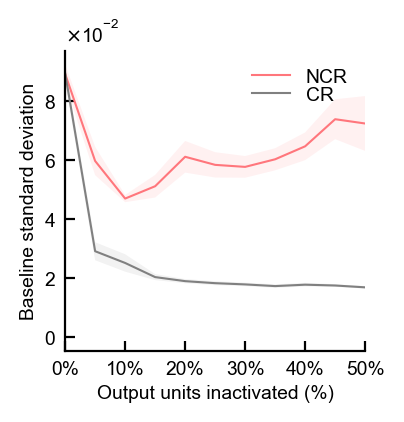

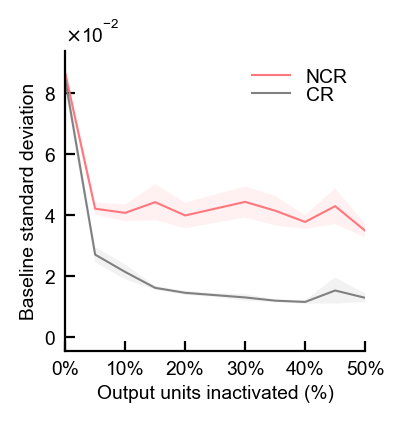

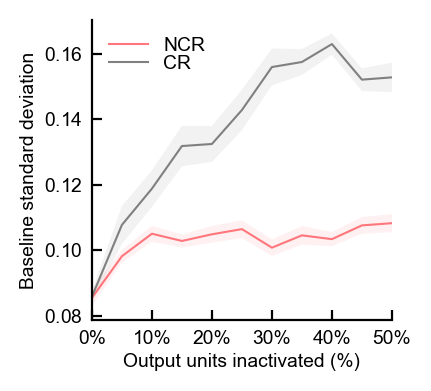

In [54]:
DIRECTORY = "/Users/insanallylab/Desktop/Experiments"
VARS = ("n_rep", "inactivation_type","inactivation_num")
# EXPERIMENTS = [("results_experiment_LIFv2_halftauIEsodr", ),
#                ("results_experiment_LIFv2_halftauIEsonr", ), 
#                 ("results_experiment_LIFv2_halftauIEnodr", )]
                
EXPERIMENTS = [("halftauIEsodr", "halftauIEsodrcat", "halftauIEsodrcat2"),
               ("halftauIEsonr", "halftauIEsonrcat", "halftauIEsonrcat2"), 
                ("halftauIEnodr", "halftauIEnodrcat", "halftauIEnodrcat2")]
names = ["full", "output", "recurrent"]
xlim = [0,100]

Stats_all = []
NNRmean_all = []
Rmean_all = []

for idx, exps in enumerate(EXPERIMENTS):
    fig, ax = make_axis_size(1.5, 1.5, .35, .3)
    name = names[idx]

    # Concatenating 
    for j, EXPERIMENT in enumerate(exps):
        if j == 0:
            perf_df = load_experiment_results(EXPERIMENT, "calculate_RMS_norm.csv", directory=DIRECTORY) 
        else:
            perf_temp = load_experiment_results(EXPERIMENT, "calculate_RMS_norm.csv", directory=DIRECTORY)
            perf_temp["n_rep"] += 8 * j 
            perf_df = perf_df.append(perf_temp)
    n_reps = perf_df["n_rep"].max()
    
    new_df = perf_df.groupby(['inactivation_type', 'inactivation_num']).mean()
    new_df["meanshiftstd_sem"] = perf_df.groupby(['inactivation_type', 'inactivation_num']).std()["meanshiftstd"] / np.sqrt(n_reps)
    
    for pop, nam, color in zip(["NNR_sorted", "R_sorted"], ["NCR", "CR"],[NNR_COLOR, R_COLOR, MIX_COLOR]):
        c_df = new_df.loc[pop]
        ax.plot(c_df.index, c_df["meanshiftstd"], color=color, label=nam, lw=.75)
        ax.fill_between(c_df.index, c_df["meanshiftstd"] - c_df["meanshiftstd_sem"], c_df["meanshiftstd"] + c_df["meanshiftstd_sem"], alpha=.1, color=color, lw=0)

    ax.legend()
    #ax.set_ylim([1.5, 4.5])
    ax.set_xlim([0, 300])
    ax.set_xticks(range(0, 330, 60))
    ax.set_xticklabels([f"{int(i/6)}%" for i in ax.get_xticks()])
    
    NAME = name+' baseline activity std inactivation'
    # fig.savefig(os.path.join(DIRECTORY, NAME+' no labels.pdf'))

    ax.set_xlabel("Output units inactivated (%)")
    #ax.set_xlabel("Number of output units inactivated")
    
    ax.set_ylabel("Baseline standard deviation")
    ax.legend(labelspacing=0)
    #ax.legend(loc="lower left", labelspacing=0)
    fig.savefig(os.path.join(DIRECTORY, NAME+'_labels.pdf'),facecolor='white')
    
    #TODO: Save csvs
    # sig2 = np.zeros(len(labels))
    # sig2[np.array(statstemp,dtype=int)] = np.ones(len(statstemp))
    # datadict = dict()
    # datadict['percent inactivation'] = labels
    # datadict['NCR mean'] = NNRmean
    # datadict['NCR sem'] = NNRsem
    # datadict['CR mean'] = Rmean
    # datadict['CR sem'] = Rsem
    # datadict['mixed mean'] = ALTmean
    # datadict['mixed sem'] = ALTsem
    # datadict['significant'] = sig2
    
    # df = pd.DataFrame(data=datadict)
    #df.to_csv(os.path.join(full_dir, NAME+'.csv'))

## Response RMS Normalized

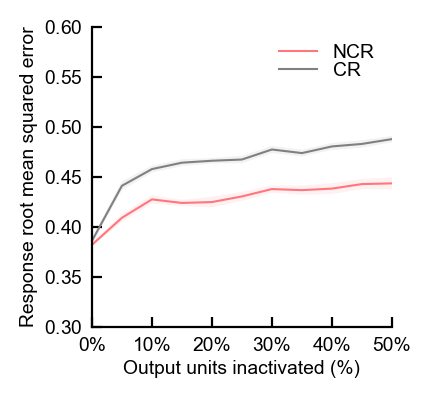

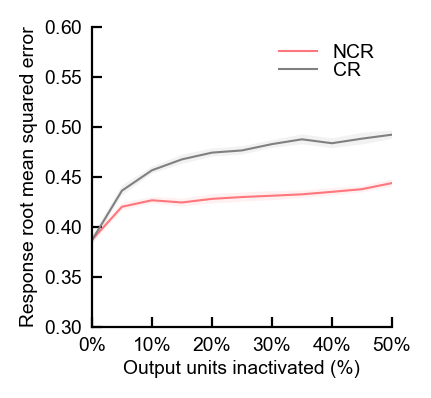

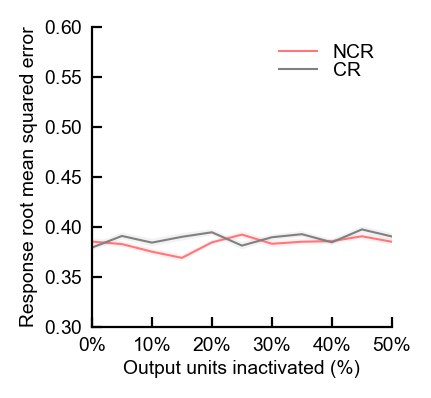

In [55]:
DIRECTORY = "/Users/insanallylab/Desktop/Experiments"
VARS = ("n_rep", "inactivation_type","inactivation_num")
# EXPERIMENTS = [("results_experiment_LIFv2_halftauIEsodr", ),
#                ("results_experiment_LIFv2_halftauIEsonr", ), 
#                 ("results_experiment_LIFv2_halftauIEnodr", )]
                
EXPERIMENTS = [("halftauIEsodr", "halftauIEsodrcat", "halftauIEsodrcat2"),
               ("halftauIEsonr", "halftauIEsonrcat", "halftauIEsonrcat2"), 
                ("halftauIEnodr", "halftauIEnodrcat", "halftauIEnodrcat2")]
names = ["full", "output", "recurrent"]
xlim = [0,100]

Stats_all = []
NNRmean_all = []
Rmean_all = []

for idx, exps in enumerate(EXPERIMENTS):
    fig, ax = make_axis_size(1.5, 1.5, .35, .3)
    name = names[idx]

    # Concatenating 
    for j, EXPERIMENT in enumerate(exps):
        if j == 0:
            perf_df = load_experiment_results(EXPERIMENT, "calculate_RMS_norm.csv", directory=DIRECTORY) 
        else:
            perf_temp = load_experiment_results(EXPERIMENT, "calculate_RMS_norm.csv", directory=DIRECTORY)
            perf_temp["n_rep"] += 8 * j 
            perf_df = perf_df.append(perf_temp)
    n_reps = perf_df["n_rep"].max()
    
    new_df = perf_df.groupby(['inactivation_type', 'inactivation_num']).mean()
    new_df["response_sem"] = perf_df.groupby(['inactivation_type', 'inactivation_num']).std()["response"] / np.sqrt(n_reps)
    
    for pop, nam, color in zip(["NNR_sorted", "R_sorted"], ["NCR", "CR"],[NNR_COLOR, R_COLOR, MIX_COLOR]):
        c_df = new_df.loc[pop]
        ax.plot(c_df.index, c_df["response"], color=color, label=nam, lw=.75)
        ax.fill_between(c_df.index, c_df["response"] - c_df["response_sem"], c_df["response"] + c_df["response_sem"], alpha=.1, color=color, lw=0)

    ax.legend()
    ax.set_ylim([0.3, 0.6])
    ax.set_xlim([0, 300])
    ax.set_xticks(range(0, 330, 60))
    ax.set_xticklabels([f"{int(i/6)}%" for i in ax.get_xticks()])
    
    NAME = name+' response rms inactivation'
    # fig.savefig(os.path.join(DIRECTORY, NAME+' no labels.pdf'))

    ax.set_xlabel("Output units inactivated (%)")
    #ax.set_xlabel("Number of output units inactivated")
    
    ax.set_ylabel("Response root mean squared error")
    ax.legend(labelspacing=0)
    #ax.legend(loc="lower left", labelspacing=0)
    fig.savefig(os.path.join(DIRECTORY, NAME+'_labels.pdf'),facecolor='white')
    
    #TODO: Save csvs
    # sig2 = np.zeros(len(labels))
    # sig2[np.array(statstemp,dtype=int)] = np.ones(len(statstemp))
    # datadict = dict()
    # datadict['percent inactivation'] = labels
    # datadict['NCR mean'] = NNRmean
    # datadict['NCR sem'] = NNRsem
    # datadict['CR mean'] = Rmean
    # datadict['CR sem'] = Rsem
    # datadict['mixed mean'] = ALTmean
    # datadict['mixed sem'] = ALTsem
    # datadict['significant'] = sig2
    
    # df = pd.DataFrame(data=datadict)
    #df.to_csv(os.path.join(full_dir, NAME+'.csv'))

full:
0:	CR/NCR	1.4984456113695968, 0.0
	CR/bl	1.4984456113695968, 0.0
	NCR/bl	1.4984456113695968, 0.0

10:	CR/NCR	9.937482515975483e-06, -0.033304911617232036
	CR/bl	6.961574597868274e-14, 0.07330432415774552
	NCR/bl	6.116283492614519e-13, 0.03999941254051348

50:	CR/NCR	5.580304438960891e-07, -0.04098554128651488
	CR/bl	6.294518358302525e-14, 0.1017419517398947
	NCR/bl	2.5784115984125407e-11, 0.06075641045337982




output:
0:	CR/NCR	1.498343324839631, 0.0
	CR/bl	1.498343324839631, 0.0
	NCR/bl	1.498343324839631, 0.0

10:	CR/NCR	6.599216838444506e-06, -0.03515072731345292
	CR/bl	3.2486372945723135e-13, 0.07389629501587264
	NCR/bl	8.749998373199068e-12, 0.038745567702419714

50:	CR/NCR	1.245016369640989e-07, -0.045461003823267565
	CR/bl	2.1358524724019634e-13, 0.10629098221065542
	NCR/bl	6.058863542473053e-13, 0.06082997838738785




recurrent:
0:	CR/NCR	1.497276300381592, 0.0
	CR/bl	1.497276300381592, 0.0
	NCR/bl	1.497276300381592, 0.0

10:	CR/NCR	0.36822750180468633, -0.0127957135362

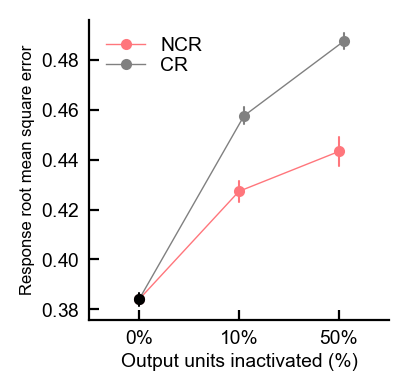

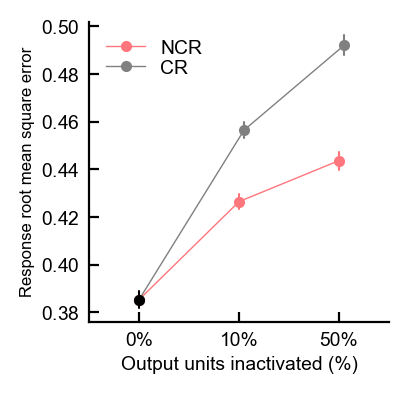

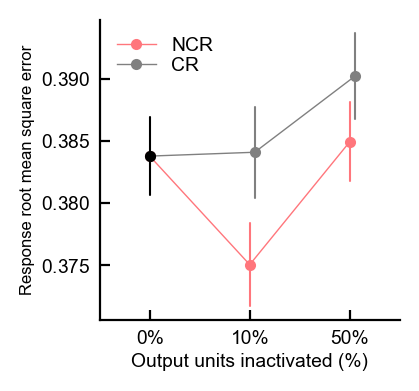

In [69]:
# Plotting as connected plots 
PLOT_NAME = "_specific_inactivation_comparisons_response_rms_norm"
N1 = 60
N2 = 300
names = ["full", "output", "recurrent"]
comp_num = [(0, 60, 300), (0, 60, 300), (0, 60, 300)]

for idx, (name, exps) in enumerate(zip(names, EXPERIMENTS)):
    fig, ax = make_axis_size(1.5, 1.5, .35, .3)
    # fig, ax = make_axis_size(1.5, 1.0, .35, .3)

    # Concatenating 
    for j, EXPERIMENT in enumerate(exps):
        if j == 0:
            perf_df = load_experiment_results(EXPERIMENT, "calculate_RMS_norm.csv", directory=DIRECTORY) 
        else:
            perf_temp = load_experiment_results(EXPERIMENT, "calculate_RMS_norm.csv", directory=DIRECTORY)
            perf_temp["n_rep"] += 8 * j 
            perf_df = perf_df.append(perf_temp)
    n_rep = np.max(perf_df["n_rep"])
    
    response = {}
    legend_handles = []
    sets = ["NCR", "CR"]
    for l, (cond, label, color) in enumerate(zip(["NNR_sorted", "R_sorted"], sets, [NNR_COLOR, R_COLOR])):
        x = l*.05
        # q1 = {}
        # q3 = {}
        m = {}
        s = {}
        response[cond] = {}
        for k, n in enumerate(comp_num[j]):
            if k == 0:
                response[cond][k] = perf_df[(perf_df["inactivation_num"] == n)]['response']
            else:
                response[cond][k] = perf_df[(perf_df['inactivation_type'] == cond) & (perf_df["inactivation_num"] == n)]['response']
            
            # q1[k] = np.percentile(d_prime[cond][k], 25)
            # q3[k] = np.percentile(d_prime[cond][k], 75)
            # m[k]  = np.percentile(d_prime[cond][k], 50)
            
            #Misses
            m[k] = np.mean(response[cond][k])
            s[k] = np.std(response[cond][k]) / np.sqrt(n_rep)
            if (n == 0):
                if (cond == "NNR_sorted"):
                    ax.plot(k + x, m[k], linestyle=None, color='k',  marker="o", ms=3, zorder=3)
                    ax.plot([k + x, k + x], [m[k] + s[k], m[k] - s[k]], linewidth=.75, solid_capstyle='round', color='k', zorder=3)
            else:
                # scat_handle = ax.plot(k + x, m[k], linestyle=None, color=color)
                ax.plot([k + x, k + x], [m[k] + s[k], m[k] - s[k]], linewidth=.75, solid_capstyle='round', color=color, zorder=1)
        #Misses
        ax.plot([0, x+1, x+2], [m[0], m[1], m[2]], lw=.5, marker="o", ms=3, color=color, zorder=2, label=label)

    test = sps.mannwhitneyu
    fac = 3
    
    print(f"{name}:")
    print(f'0:\tCR/NCR\t{test(response["NNR_sorted"][0], response["R_sorted"][0]).pvalue*fac}, {np.median(response["NNR_sorted"][0]) - np.median(response["R_sorted"][0])}')
    print(f'\tCR/bl\t{test(response["R_sorted"][0], response["R_sorted"][0]).pvalue*fac}, {np.median(response["R_sorted"][0]) - np.median(response["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(response["NNR_sorted"][0], response["NNR_sorted"][0]).pvalue*fac}, {np.median(response["NNR_sorted"][0]) - np.median(response["NNR_sorted"][0])}\n')
    
    print(f'10:\tCR/NCR\t{test(response["NNR_sorted"][1], response["R_sorted"][1]).pvalue*fac}, {np.median(response["NNR_sorted"][1]) - np.median(response["R_sorted"][1])}')
    print(f'\tCR/bl\t{test(response["R_sorted"][1], response["R_sorted"][0]).pvalue*fac}, {np.median(response["R_sorted"][1]) - np.median(response["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(response["NNR_sorted"][1], response["NNR_sorted"][0]).pvalue*fac}, {np.median(response["NNR_sorted"][1]) - np.median(response["NNR_sorted"][0])}\n')
    
    print(f'50:\tCR/NCR\t{test(response["NNR_sorted"][2], response["R_sorted"][2]).pvalue*fac}, {np.median(response["NNR_sorted"][2]) - np.median(response["R_sorted"][2])}')
    print(f'\tCR/bl\t{test(response["R_sorted"][2], response["R_sorted"][0]).pvalue*fac}, {np.median(response["R_sorted"][2]) - np.median(response["R_sorted"][0])}')
    print(f'\tNCR/bl\t{test(response["NNR_sorted"][2], response["NNR_sorted"][0]).pvalue*fac}, {np.median(response["NNR_sorted"][2]) - np.median(response["NNR_sorted"][0])}\n')
    
    print(f"\n\n")


    ax.set_xlim([-.5, 2.5])
    #ax.set_ylim([0, 15])
    ax.set_xticks([0,1, 2])
    ax.set_xticklabels(["0%", "10%", "50%"])
    #ax.set_yticklabels([f"{int(i)}%" for i in ax.get_yticks()])
    ax.legend(loc="upper left", labelspacing=0.1)
    ax.set_ylabel("Response root mean square error", size=6)
    ax.set_xlabel("Output units inactivated (%)")
    fig.savefig(os.path.join(DIRECTORY, name + PLOT_NAME+'.pdf'))
    

